In [2]:
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import seaborn as sns
import gc
import torch
import torch.nn as nn
import torch.optim as optimizers
from scipy.stats import norm
from numpy.random import *
from scipy import optimize

np.random.seed(98537)

In [3]:
# 多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.array(np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1), dtype="int")
    return z_id

In [4]:
# データの生成
# データの設定
k = 12
k_vec = np.repeat(1, k)
hh = 5000
item = 3000
Lambda = np.random.gamma(40.0, 1/0.2, hh)
pt = np.random.poisson(Lambda, hh)
N = np.sum(pt)

In [5]:
# idとインデックスの設定
# idの設定
d_id = np.repeat(np.arange(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

# インデックスの設定
d_list = [i for i in range(hh)]
for i in range(hh):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")

In [6]:
# 素性ベクトルの生成
k1 = 2; k2 = 4; k3 = 4
x1 = np.random.normal(0.0, 0.5, k1*N).reshape(N, k1)
x2 = np.zeros((N, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, N)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), N)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x = np.hstack((np.repeat(1.0, N)[:, np.newaxis], x1, x2, x3))
col = x.shape[1]

In [7]:
# アイテムの生成
# 多項分布からトピックを生成
topic = 30
theta_topic = np.random.dirichlet(np.repeat(0.2, topic), hh)
phi_topic = np.random.dirichlet(np.repeat(0.2, item), topic)
z = rmnom(theta_topic[d_id, ], N, topic, 0)

# トピックからアイテムを生成
item_id = np.repeat(0, N)
for i in range(hh):
    index = d_list[i]
    item_id[index] = rmnom(phi_topic[z[d_list[i]], ], pt[i], item, 0)
    
# インデックスの設定
item_list = [i for i in range(item)]
item_n = np.repeat(0, item)
for i in range(item):
    item_list[i] = np.array(np.where(item_id==i)[0], dtype="int")
    item_n[i] = item_list[i].shape[0]

In [8]:
# 応答変数の生成
per_min = 75; per_max = 75
rp = 0
while True:
    rp = rp + 1
    
    # 階層モデルのパラメータを生成
    alpha = 0.0
    alpha_u = np.repeat(1.0, k)
    alpha_v = np.repeat(0.0, k)
    Cov_u = np.diag(np.append(0.5, np.repeat(0.5, k)))
    Cov_v = np.diag(np.append(0.7, np.repeat(0.7, k)))
    Covt_u = Cov_u.copy(); Covt_v = Cov_v.copy()

    # モデルパラメータを生成
    beta = np.append(-1.0, np.random.normal(0.0, 0.7, col-1))
    beta_u = np.random.normal(0.0, Cov_u[0, 0], hh)
    beta_v = np.random.normal(0.0, Cov_v[0, 0], item)
    theta_u = np.random.multivariate_normal(alpha_u, Cov_u[1:, 1:], hh)
    theta_v = np.random.multivariate_normal(alpha_v, Cov_v[1:, 1:], item)
    betat = beta.copy(); betat_u = beta_u.copy(); betat_v = beta_v.copy()
    thetat_u = theta_u.copy(); thetat_v = theta_v.copy()
        
    # モデルの期待値
    beta_mu = np.dot(x, beta)
    uv = np.sum(theta_u[d_id, ] * theta_v[item_id, ], axis=1)
    mu = beta_u[d_id] + beta_v[item_id] + beta_mu + uv

    #ベルヌーイ分布から応答変数を生成
    Prob = np.exp(mu) / (1 + np.exp(mu))
    y = np.random.binomial(1, Prob, N)
    y_vec = y[:, np.newaxis]

    #break条件
    if (np.mean(y) > 0.2) & (np.mean(y) < 0.4):
        break

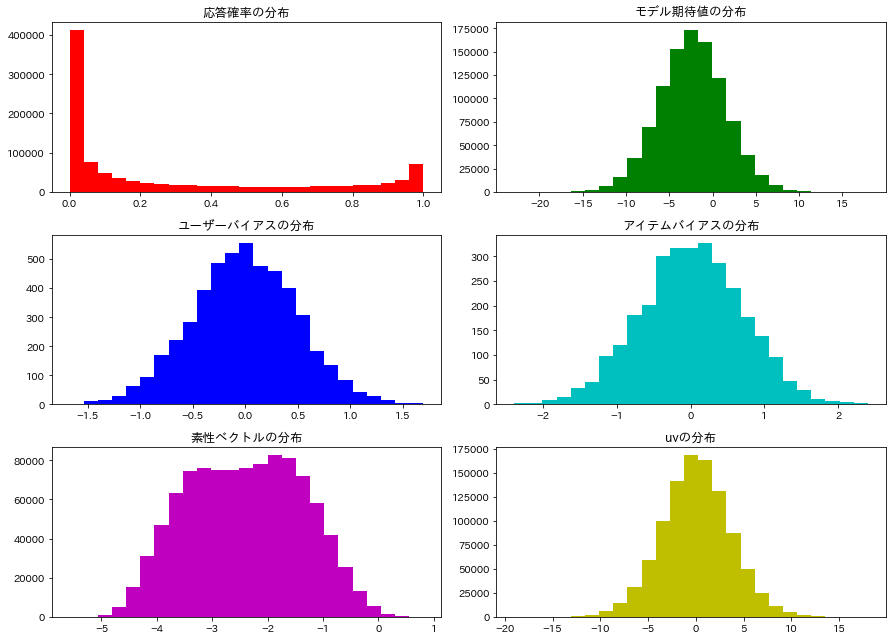

In [9]:
#潜在変数ごとのヒストグラム
dt = [Prob, mu, beta_u, beta_v, beta_mu, uv]
fig_range = np.append(np.array([0, np.min(mu), np.min(beta_u), np.min(beta_v), np.min(beta_mu), np.min(uv)]), 
                      np.array([1.0, np.max(mu), np.max(beta_u), np.max(beta_v), np.max(beta_mu), np.max(uv)])).reshape(2, len(dt))
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
legend = ["応答確率の分布", "モデル期待値の分布", "ユーザーバイアスの分布", "アイテムバイアスの分布", "素性ベクトルの分布", "uvの分布"]
fig = plt.figure(figsize=(12.5, 9.0))
for j in range(len(dt)):
    ax = fig.add_subplot(3, 2, j+1)
    ax.hist(dt[j],  bins=25, range=(fig_range[0, j], fig_range[1, j]), color=colorlist[j])
    plt.title(legend[j], fontsize=12.5)
fig.tight_layout()
plt.show()

In [10]:
# テストデータの生成
# ユーザーidの生成
m = np.random.poisson(np.random.gamma(40.0, 1/0.2, hh))
M = np.sum(m)
d_id0 = np.repeat(np.arange(hh), m)

# インデックスの設定
d_list0 = [i for i in range(hh)]
for i in range(hh):
    d_list0[i] = np.array(np.where(d_id0==i)[0], dtype="int")

# 素性ベクトルを生成
x1 = np.random.normal(0.0, 0.5, k1*M).reshape(M, k1)
x2 = np.zeros((M, k2))
for j in range(k2):
    prob = np.random.uniform(0.25, 0.55, 1)
    x2[:, j] = np.random.binomial(1, prob, M)
x3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(2.5, k3), 1).reshape(k3), M)
x3 = np.delete(x3, np.argmin(np.sum(x3, axis=0)), axis=1)   #冗長な変数の削除
x0 = np.hstack((np.repeat(1.0, M)[:, np.newaxis], x1, x2, x3))

# アイテムの生成
# 多項分布からトピックを生成
z = rmnom(theta_topic[d_id0, ], M, topic, 0)

# トピックからアイテムを生成
item_id0 = np.repeat(0, M)
for i in range(hh):
    index = d_list0[i]
    item_id0[index] = rmnom(phi_topic[z[d_list0[i]], ], m[i], item, 0)

In [11]:
# 応答変数の生成
# モデルの期待値
beta_mu = np.dot(x0, beta)
uv = np.sum(theta_u[d_id0, ] * theta_v[item_id0, ], axis=1)
mu = beta_u[d_id0] + beta_v[item_id0] + beta_mu + uv

# ベルヌーイ分布から応答変数を生成
Prob = np.exp(mu) / (1 + np.exp(mu))
y0 = np.random.binomial(1, Prob, M)
y_vec0 = y0[:, np.newaxis]

In [128]:
# モデルの定義
a = nn.Embedding(num_embeddings=hh, embedding_dim=k)

In [32]:
(a1[d_id, ] * b1[item_id, ]).sum(1)

tensor([-0.3627, -1.2413,  1.6099,  ...,  0.0658,  7.5577, -1.3139])

In [64]:
a = nn.Linear(in_features=k, out_features=1, bias=False)

In [152]:
a1 = np.array(theta_u, dtype="float64")
a2 = np.array(theta_v, dtype="float64")

In [153]:
%%time
for i in range(100):
    ab = np.dot(a1[d_id, ] * a2[item_id, ], k_vec)

Wall time: 12.6 s


In [179]:
a1 = torch.DoubleTensor(theta_u)
b1 = torch.DoubleTensor(theta_v)
id1 = torch.LongTensor(d_id)
id2 = torch.LongTensor(item_id)

In [164]:
%%time
for i in range(100):
    ab = np.array((a1[d_id, ] * b1[item_id, ]).sum(1))

Wall time: 4.56 s


In [182]:
a1

tensor([[ 1.3591, -0.6231, -1.0760,  ...,  1.2531,  1.8027,  2.0068],
        [ 1.6567,  1.8032,  1.6066,  ...,  0.8183,  0.7993,  1.5722],
        [ 1.3839,  1.5447,  1.6201,  ...,  1.3737, -0.4480,  1.0718],
        ...,
        [ 0.8636,  1.4008,  1.9591,  ...,  0.5713,  2.2527,  1.6468],
        [ 1.0203,  1.1269,  1.2333,  ...,  1.3830,  1.3720,  1.4658],
        [ 0.7780,  1.4588,  0.9749,  ...,  1.9301,  1.6513,  0.6660]],
       dtype=torch.float64)

In [47]:
index_allocation1 = np.repeat(np.arange(k), k)
index_allocation2 = np.tile(np.arange(k), k)
np.sum(theta_u[:, index_allocation1][d_id, ] * theta_v[:, index_allocation2][item_id, ], axis=1)

array([  0.63737702,  -0.2448403 ,  18.03240567, ...,   2.59637848,
        83.04696264, -10.23031842])

In [ ]:
index_allocation1 
